In [1]:
# niezbędne importy i wczytanie danych
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

df = pd.read_csv('./otpdata/itineraries.csv', sep = ';')
df['legs'] = df['legs'].apply(ast.literal_eval)
df['route_coordinates'] = df['route_coordinates'].apply(ast.literal_eval)
rt_df = pd.read_csv('./otpdata/rt_itineraries.csv', sep = ';')
rt_df['legs'] = rt_df['legs'].apply(ast.literal_eval)
rt_df['route_coordinates'] = rt_df['route_coordinates'].apply(ast.literal_eval)

# TODO:
~~rozkład czasów oczekiwania na przesiadki~~
~~parametry istotne z punktu widzenia pasażera~~  
~~sprawdzenie na ile gtfs trasy są sensowne dla rt-gtfs (zakodowana jest krzywa trasy, możnaby porównać czy to ta sama trasa) - od tego zacząć~~  
    - to odpowie na pytanie czy kazał nam drastycznie zmienić trasę   
~~ czas rzeczywisty~~   
~~dojscie do przystanku~~  
~~porównanie rozkładów spaceru (czas / dystans)~~  
liczba przesiadek  
sprawdzić jak pierwsza, druga, trzecia występują w rt  
leg geometry (googlowski algorytm na odczytywanie krzywej)  

In [33]:
print(df.columns)
df.head(1)

Index(['response_nr', 'requestParameters.date', 'requestParameters.time',
       'plan.from.lon', 'plan.from.lat', 'plan.to.lon', 'plan.to.lat',
       'itinerary_nr', 'duration', 'startTime', 'endTime', 'walkTime',
       'transitTime', 'waitingTime', 'walkDistance', 'walkLimitExceeded',
       'generalizedCost', 'transfers', 'legs', 'location_from_name',
       'location_to_name', 'route_coordinates', 'route_coordinates_str'],
      dtype='object')


response_nr requestParameters.date requestParameters.time  plan.from.lon  \
0            0             2022-03-30                 6:30am      21.053933   

   plan.from.lat  plan.to.lon  plan.to.lat  itinerary_nr  duration  \
0      52.234521    21.090498    52.165201             0      2881   

             startTime  ... waitingTime  walkDistance  walkLimitExceeded  \
0  2022-03-30 04:35:52  ...         459       1019.98               True   

   generalizedCost  transfers  \
0             5414          2   

                                                legs  location_from_name  \
0  [{'startTime': 1648614952000, 'endTime': 16486...           francuska   

   location_to_name                                  route_coordinates  \
0    muzeum_wilanow  [[21.05398, 52.23453], [21.05396, 52.23456], [...   

                               route_coordinates_str  
0  [[21.05398, 52.23453], [21.05396, 52.23456], [...  

[1 rows x 23 columns]

# drawing the route

### start and end points for routes

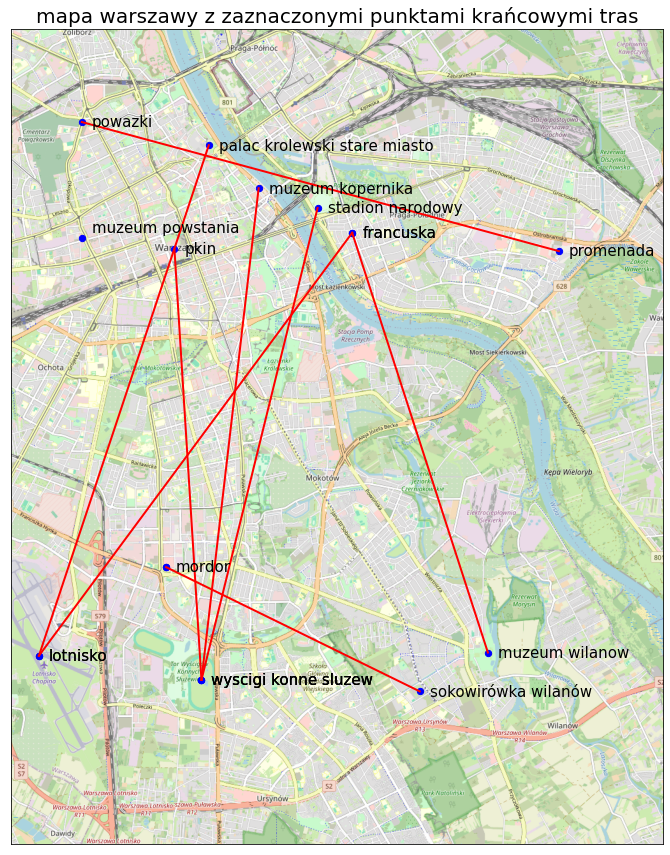

In [9]:
import contextily as ctx
import matplotlib.pyplot as plt
import xyzservices.providers as xyz
import pyproj

target_crs = 'EPSG:3857'
transformer = pyproj.Transformer.from_crs('EPSG:4326', target_crs)
subset = df[['plan.from.lat', 'plan.from.lon', 'plan.to.lat', 'plan.to.lon', 'location_from_name', 'location_to_name']].drop_duplicates()

lons = [20.9, 21.1]
lats = [52.1, 52.3]
lats = list(subset['plan.from.lat']) + list(subset['plan.to.lat'])
lons = list(subset['plan.from.lon']) + list(subset['plan.to.lon'])


# Bounding box
min_lon = min(lons)
max_lon = max(lons)
min_lat = min(lats)
max_lat = max(lats)

# Get the background image and extent using ctx.bounds2img
warsaw_img, warsaw_extent = ctx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=ctx.providers.OpenStreetMap.Mapnik)
# Plot the basemap
fig, ax = plt.subplots(figsize=(12, 15))
ax.imshow(warsaw_img, extent=warsaw_extent)

# Plot the background image 
for i, row in subset.iterrows():
    projected_lat, projected_lon = transformer.transform(row['plan.from.lat'], row['plan.from.lon'])
    projected_lat2, projected_lon2 = transformer.transform(row['plan.to.lat'], row['plan.to.lon'])
    plt.scatter(projected_lat, projected_lon, color = 'blue', s = 40)
    plt.scatter(projected_lat2, projected_lon2, color = 'blue', s = 40)
    if row['location_from_name'] == 'muzeum_powstania':
        plt.annotate(f'{row["location_from_name"].replace("_", " ")}',(projected_lat, projected_lon), textcoords="offset points", xytext=(10,5), fontsize=15)
    elif row['location_to_name'] == 'muzeum_powstania':
        plt.annotate(f'{row["location_to_name"].replace("_", " ")}',(projected_lat2, projected_lon2), textcoords="offset points", xytext=(10,5), fontsize=15)
    else:
        plt.annotate(f'{row["location_from_name"].replace("_", " ")}',(projected_lat, projected_lon), textcoords="offset points", xytext=(10,-5), fontsize=15)
        plt.annotate(f'{row["location_to_name"].replace("_", " ")}',(projected_lat2, projected_lon2), textcoords="offset points", xytext=(10,-5), fontsize=15)
        plt.plot([projected_lat, projected_lat2], [projected_lon, projected_lon2], linewidth = 2, c = 'red')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title('mapa warszawy z zaznaczonymi punktami krańcowymi tras', fontsize = 20)
plt.savefig('../outputs/OTP/benchmark/startpoints.png', dpi = 200)

In [63]:
def decode(point_str):
    coord_chunks = [[]]
    
    for char in point_str:
        value = ord(char) - 63
        split_after = not (value & 0x20)
        value &= 0x1F
        coord_chunks[-1].append(value)
        
        if split_after:
            coord_chunks.append([])
    
    coord_chunks.pop()

    coords = []

    for coord_chunk in coord_chunks:
        coord = 0

        for i, value in enumerate(coord_chunk):
            coord |= value << (i * 5)

        if coord & 0x1:
            coord = ~coord
        coord >>= 1
        coord /= 100000.0

        coords.append(coord)

    points = []
    prev_x, prev_y = 0, 0

    for i in range(0, len(coords) - 1, 2):
        if coords[i] == 0 and coords[i + 1] == 0:
            continue

        prev_x += coords[i + 1]
        prev_y += coords[i]
        points.append([round(prev_x, 6), round(prev_y, 6)])

    return points

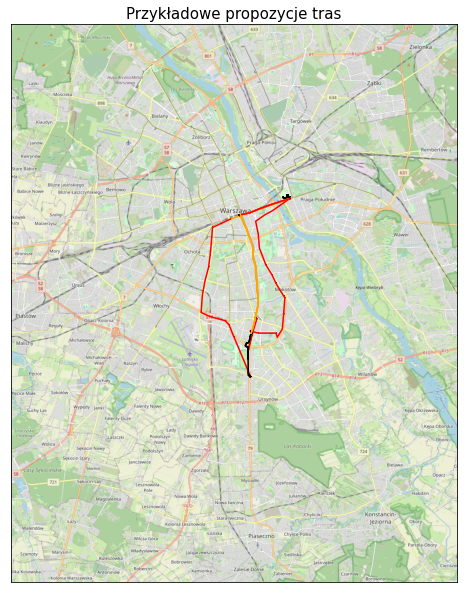

In [64]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import xyzservices.providers as xyz
import pyproj

target_crs = 'EPSG:3857'
transformer = pyproj.Transformer.from_crs('EPSG:4326', target_crs)


lons = [20.9, 21.1]
lats = [52.1, 52.3]

# Bounding box
min_lon = min(lons)
max_lon = max(lons)
min_lat = min(lats)
max_lat = max(lats)

# Get the background image and extent using ctx.bounds2img
warsaw_img, warsaw_extent = ctx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=ctx.providers.OpenStreetMap.Mapnik)

# Plot the basemap
fig, ax = plt.subplots(figsize=(8, 12))

# Plot the background image
ax.imshow(warsaw_img, extent=warsaw_extent)
# Plot the route data
for legs in rt_df[rt_df['response_nr'] == 6]['legs']:
    for leg in legs:
        lats, lons = zip(*decode((leg['legGeometry'])['points']))
        lon_lat_pairs = list(zip(lons, lats))
        projected_coords = [transformer.transform(lon, lat) for lon, lat in lon_lat_pairs]
        projected_lons, projected_lats = zip(*projected_coords)
        mode = leg['mode']
        modes = {'WALK': 'black', 'BUS': 'red', 'TRAM' : 'orange'}
        ax.plot(projected_lons, projected_lats, marker=',', linestyle='-', color=modes.get(mode, 'blue'))  # Default to blue for unknown modes
# ax.axis(warsaw_extent)
plt.title('Przykładowe propozycje tras', fontsize = 15)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.savefig('../outputs/OTP/benchmark/example_routes_rt.png', dpi = 200)
# ax.axis(warsaw_extent)
plt.show()

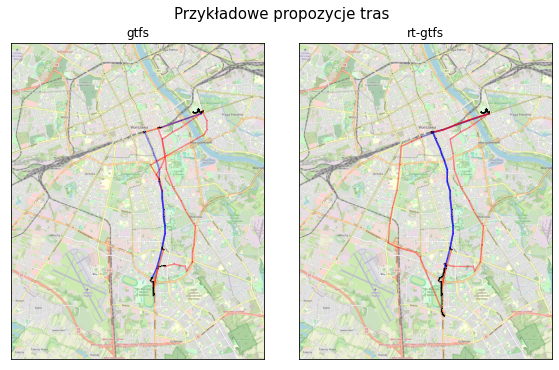

In [67]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import xyzservices.providers as xyz
import pyproj

target_crs = 'EPSG:3857'
transformer = pyproj.Transformer.from_crs('EPSG:4326', target_crs)


lons = [20.95, 21.05]
lats = [52.15, 52.25]

# Bounding box
min_lon = min(lons)
max_lon = max(lons)
min_lat = min(lats)
max_lat = max(lats)

# Get the background image and extent using ctx.bounds2img
warsaw_img, warsaw_extent = ctx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=ctx.providers.OpenStreetMap.Mapnik)

# Plot the basemap
fig, ax = plt.subplots(1,2, figsize=(8, 5), sharex=True)
fig.subplots_adjust(left=0, bottom=0, right=1, top=None, wspace=0, hspace=0)

# Plot the background image
ax[0].imshow(warsaw_img, extent=warsaw_extent)
ax[1].imshow(warsaw_img, extent=warsaw_extent)
# Plot the route data
for legs in df[df['response_nr'] == 7]['legs']:
    for leg in legs:
        lats, lons = zip(*decode((leg['legGeometry'])['points']))
        lon_lat_pairs = list(zip(lons, lats))
        projected_coords = [transformer.transform(lon, lat) for lon, lat in lon_lat_pairs]
        projected_lons, projected_lats = zip(*projected_coords)
        mode = leg['mode']
        modes = {'WALK': 'black', 'BUS': 'red', 'TRAM' : 'blue'}
        ax[0].plot(projected_lons, projected_lats, marker=',', linestyle='-', color=modes.get(mode, 'pink'), alpha = 0.4)  # Default to pink for unknown modes
for legs in rt_df[rt_df['response_nr'] == 6]['legs']:
    for leg in legs:
        lats, lons = zip(*decode((leg['legGeometry'])['points']))
        lon_lat_pairs = list(zip(lons, lats))
        projected_coords = [transformer.transform(lon, lat) for lon, lat in lon_lat_pairs]
        projected_lons, projected_lats = zip(*projected_coords)
        mode = leg['mode']
        modes = {'WALK': 'black', 'BUS': 'red', 'TRAM' : 'blue'}
        ax[1].plot(projected_lons, projected_lats, marker=',', linestyle='-', color=modes.get(mode, 'pink'), alpha = 0.4)  # Default to pink for unknown modes
# ax.axis(warsaw_extent)
plt.suptitle('Przykładowe propozycje tras', fontsize = 15)
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
plt.grid(False)
ax[0].set_title('gtfs')
ax[1].set_title('rt-gtfs')
plt.savefig('../outputs/OTP/benchmark/example_routes_comparison.png', dpi = 200)

# ax.axis(warsaw_extent)
plt.show()

# EDA

waitingTime gtfs 225s	 rt-gtfs 258s
duration gtfs 3278s	 rt-gtfs 3388s
transitTime gtfs 1772s	 rt-gtfs 1856s
walkTime gtfs 1282s	 rt-gtfs 1274s


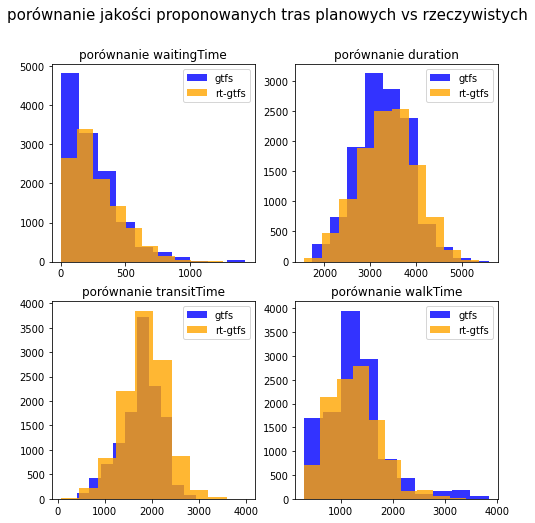

In [3]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(8,8)
for ax, colname in zip(np.asarray(axes).flatten(), ['waitingTime', 'duration',  'transitTime', 'walkTime', 'arrival_delay']):
    ax.hist(df[[colname]], alpha = 0.8, label = 'gtfs', color = 'blue')
    ax.hist(rt_df[[colname]], alpha = 0.8, label = 'rt-gtfs', color = 'orange')
    ax.set_title(f'porównanie {colname}')
    ax.legend()
    print(f'{colname} gtfs {round(np.mean(df[colname] ))}s\t rt-gtfs {round(np.mean(rt_df[colname] ))}s')
plt.suptitle('porównanie jakości proponowanych tras planowych vs rzeczywistych', fontsize = 15)

plt.savefig('../outputs/OTP/benchmark/histograms_full.png')
plt.show()


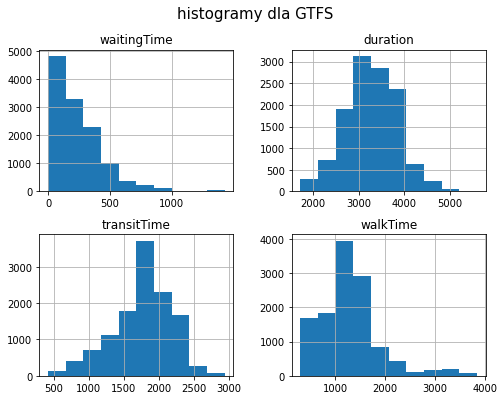

In [119]:
import warnings
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
df[['waitingTime', 'duration',  'transitTime', 'walkTime']].hist(ax=ax)
plt.suptitle('histogramy dla GTFS', fontsize = 15)
plt.savefig('../outputs/OTP/benchmark/histograms_gtfs.png')
plt.show()

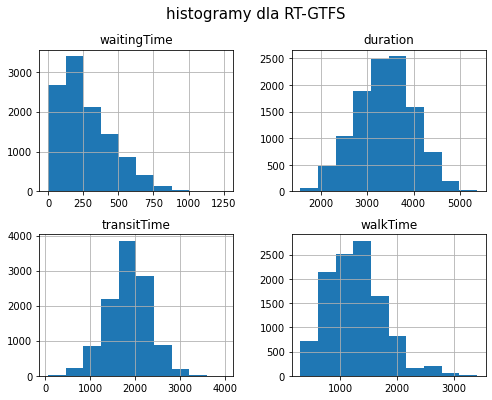

In [120]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
rt_df[['waitingTime', 'duration',  'transitTime', 'walkTime']].hist(ax=ax)
warnings.filterwarnings('default')
plt.suptitle('histogramy dla RT-GTFS', fontsize = 15)
plt.savefig('../outputs/OTP/benchmark/histograms_rt_gtfs.png')

proportion of advertised routes that are realisable 0.14971381847914964
mean delay 81s
1369


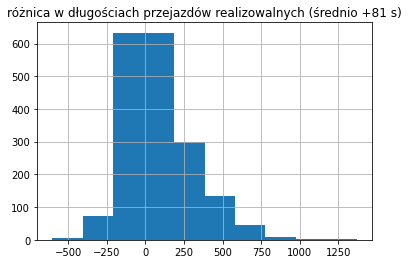

In [179]:
df_merged = df.merge(rt_df, on = ['requestParameters.date', 'requestParameters.time', 'route_coordinates_str'], how = 'inner', suffixes=['_expected', '_real'])
print(f'proportion of advertised routes that are realisable {df_merged.shape[0]/df.shape[0]}')
df_merged['time_difference'] = df_merged[['duration_expected', 'duration_real']].apply(lambda x: x.duration_real - x.duration_expected, axis=1)
df_merged['time_difference'].hist()
plt.title('różnica w długościach przejazdów realizowalnych (średnio +81 s)')
plt.savefig('../outputs/OTP/benchmark/delays_realisable.png', dpi = 200)
print(f'mean delay {round(df_merged["time_difference"].mean())}s\n{round(np.max(df_merged["time_difference"]))}')

-131.38853086765667
proportion of advertised routes that are realisable 0.14971381847914964
80.8219552157291


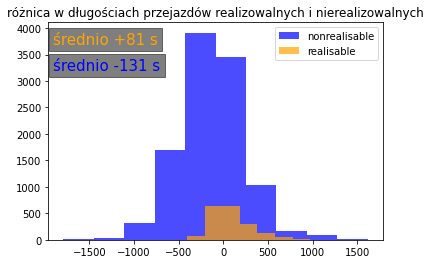

In [305]:
fig, ax= plt.subplots(1,1)
min_indices = rt_df.groupby(['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'])['duration'].idxmin()
filtered_rt_df = rt_df.loc[min_indices]
min_indices = df.groupby(['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'])['duration'].idxmin()
filtered_df = df.loc[min_indices]
merged_df = df.merge(filtered_rt_df, on = ['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'], how = 'left', suffixes=['_expected', '_real'])
delays = merged_df['duration_real'] - merged_df['duration_expected']
print(np.mean(delays))
ax.hist(delays, alpha = 0.7, label = 'nonrealisable', color = 'blue')


merged_df = df.merge(rt_df, on = ['requestParameters.date', 'requestParameters.time', 'route_coordinates_str'], how = 'inner', suffixes=['_expected', '_real'])
print(f'proportion of advertised routes that are realisable {df_merged.shape[0]/df.shape[0]}')
delays = merged_df['duration_real'] - merged_df['duration_expected']
print(np.mean(delays))
ax.hist(delays, alpha = 0.7, label = 'realisable', color = 'orange')
plt.legend()
t = ax.text(s = "średnio +81 s", color = 'orange', x = -1900, y = 3700, fontsize = 15)
t.set_bbox(dict(facecolor='black', alpha = 0.5, edgecolor='black'))
t = ax.text(s = "średnio -131 s", color = 'blue', x = -1900, y = 3200, fontsize = 15)
t.set_bbox(dict(facecolor='black', alpha = 0.5, edgecolor='black'))
plt.title('różnica w długościach przejazdów realizowalnych i nierealizowalnych')

# plt.title('rozkład różnic w czasach trwania najlepszych tras rzeczywistych i planowych (średnio -131 s)')
plt.savefig('../outputs/OTP/benchmark/delays.png', dpi = 200)
plt.show()


histogram liczby przesiadek po grupach (realisable nonrealisable)

# sprawdzanie na ile trasy z gtfs występują w rt-gtfs 

In [2]:
df_merged = df.merge(rt_df, on = ['requestParameters.date', 'requestParameters.time', 'route_coordinates_str'], how = 'left', suffixes=['_expected', '_real'])
df_merged['time_difference'] = df_merged[['duration_expected', 'duration_real']].apply(lambda x: x.duration_real - x.duration_expected, axis=1)
df['realisable'] = [not x for x in np.isnan(df_merged['time_difference'])]
df_merged['realisable'] = df['realisable']
df['arrival_delay'] = (pd.to_datetime(df_merged[df_merged['realisable']]['endTime_real'])-pd.to_datetime(df_merged[df_merged['realisable']]['endTime_expected'])).dt.total_seconds()

df_merged = df.merge(rt_df, on = ['requestParameters.date', 'requestParameters.time', 'route_coordinates_str'], how = 'right', suffixes=['_expected', '_real'])
df_merged['time_difference'] = df_merged[['duration_expected', 'duration_real']].apply(lambda x: x.duration_real - x.duration_expected, axis=1)
rt_df['realisable'] = [not x for x in np.isnan(df_merged['time_difference'])]

waitingTime gtfs 153s	 rt-gtfs 180s
duration gtfs 3093s	 rt-gtfs 3174s
transitTime gtfs 1662s	 rt-gtfs 1715s
walkTime gtfs 1278s	 rt-gtfs 1278s
arrival_delay gtfs 140s


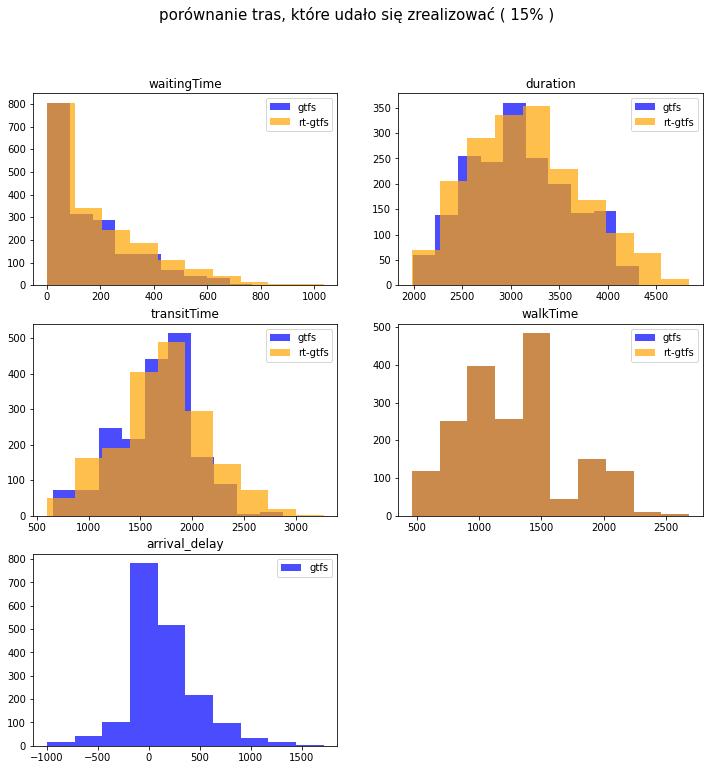

In [27]:
fig, axes = plt.subplots(3,2)
fig.set_size_inches(12,12)
df_realisable = df[df['realisable']]
rt_df_realisable = rt_df[rt_df['realisable']]
for ax, colname in zip(np.asarray(axes).flatten(), ['waitingTime', 'duration',  'transitTime', 'walkTime', 'arrival_delay']):
    
    ax.hist(df_realisable[[colname]], alpha = 0.7, label = 'gtfs', color = 'blue')
    if colname == 'arrival_delay':
        pass
    else:
        ax.hist(rt_df_realisable[[colname]], alpha = 0.7, label = 'rt-gtfs', color = 'orange')
    ax.set_title(f'{colname}')
    ax.legend()
    if colname == 'arrival_delay':
        print(f'{colname} gtfs {round(np.mean(df_realisable[colname] ))}s')
    else:
        print(f'{colname} gtfs {round(np.mean(df_realisable[colname] ))}s\t rt-gtfs {round(np.mean(rt_df_realisable[colname] ))}s')
plt.suptitle('porównanie tras, które udało się zrealizować ( 15% )', fontsize = 15)
fig.delaxes(np.asarray(axes).flatten()[-1])
plt.savefig('../outputs/OTP/benchmark/histograms_realisable.png')
plt.show()

waitingTime gtfs 237s	 rt-gtfs 274s
duration gtfs 3311s	 rt-gtfs 3431s
transitTime gtfs 1791s	 rt-gtfs 1884s
walkTime gtfs 1283s	 rt-gtfs 1274s


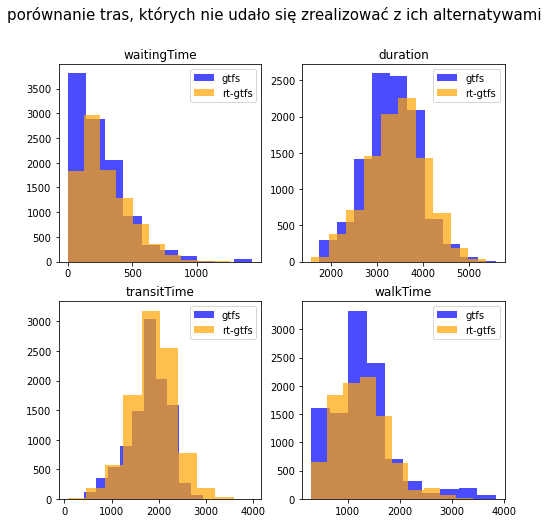

In [7]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(8,8)
df_nonrealisable = df[np.negative(df['realisable'])]
rt_df_nonrealisable = rt_df[np.negative(rt_df['realisable'])]
for ax, colname in zip(np.asarray(axes).flatten(), ['waitingTime', 'duration',  'transitTime', 'walkTime']):
    ax.hist(df_nonrealisable[[colname]], alpha = 0.7, label = 'gtfs', color = 'blue')
    ax.hist(rt_df_nonrealisable[[colname]], alpha = 0.7, label = 'rt-gtfs', color = 'orange')
    ax.set_title(f'{colname}')
    ax.legend()
    print(f'{colname} gtfs {round(np.mean(df_nonrealisable[colname] ))}s\t rt-gtfs {round(np.mean(rt_df_nonrealisable[colname] ))}s')
    
plt.suptitle('porównanie tras, których nie udało się zrealizować z ich alternatywami', fontsize = 15)
plt.savefig('../outputs/OTP/benchmark/histograms_nonrealisable.png')
plt.show()


140.25559803386128


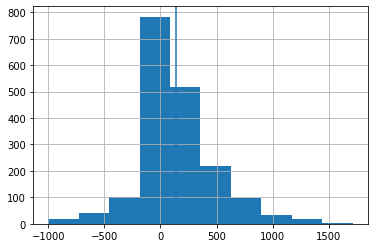

In [19]:
df_merged = df.merge(rt_df, on = ['requestParameters.date', 'requestParameters.time', 'route_coordinates_str'], how = 'left', suffixes=['_expected', '_real'])
df_merged['time_difference'] = df_merged[['duration_expected', 'duration_real']].apply(lambda x: x.duration_real - x.duration_expected, axis=1)
df_merged['realisable'] = [not x for x in np.isnan(df_merged['time_difference'])]
df['arrival_delay'] = (pd.to_datetime(df_merged[df_merged['realisable']]['endTime_real'])-pd.to_datetime(df_merged[df_merged['realisable']]['endTime_expected'])).dt.total_seconds()

realisable - transfers
0    806
1    772
2    251
3      2
Name: realisable, dtype: int64
 nonrealisable - transfers
0    3542
1    6178
2    2250
3     260
Name: realisable, dtype: int64


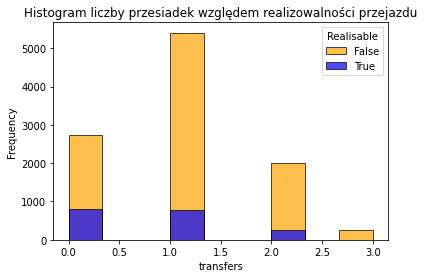

<Figure size 432x288 with 0 Axes>

In [125]:
colors = {False: 'orange', True: 'blue'}
print(f"realisable - {df.groupby('transfers')['realisable'].sum()}\n nonrealisable - {df.groupby('transfers')['realisable'].count()}")
# Iterate through groups and set colors based on the 'realisable' values
for name, group in df.groupby('realisable')['transfers']:
    plt.hist(group, alpha=0.7, bins=9, edgecolor='black', color=colors[name], label=name)

plt.xlabel('transfers')
plt.ylabel('Frequency')
plt.legend(title='Realisable')
plt.title('Histogram liczby przesiadek względem realizowalności przejazdu')

plt.show()
plt.savefig('../outputs/OTP/benchmark/histograms_nonrealisable.png')

# pierdoły

In [133]:
df.groupby('requestParameters.date')['realisable'].count().sort_values(ascending=False)

requestParameters.date
2022-06-16    232
2022-04-13    232
2022-05-25    232
2022-05-24    232
2022-05-19    232
2022-06-21    231
Name: realisable, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

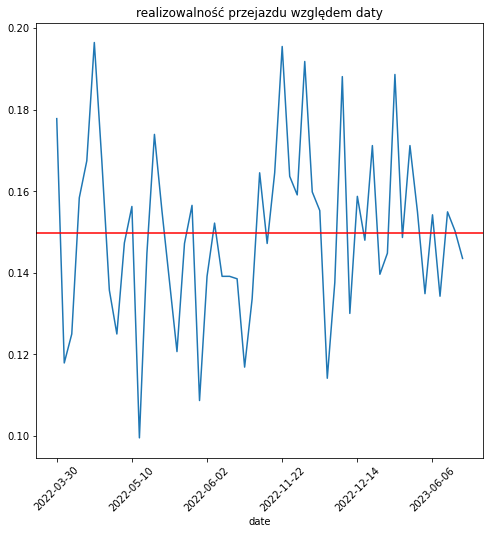

In [215]:
fig = plt.figure(figsize = (8,8))
(df.groupby('requestParameters.date')['realisable'].sum().sort_values(ascending=False)/df.groupby('requestParameters.date')['realisable'].count().sort_values(ascending=False)).plot()
plt.axhline(y = df['realisable'].sum()/df['realisable'].count(), c = 'red')
plt.xlabel('date')
plt.title('realizowalność przejazdu względem daty')
plt.xticks(rotation = 45)
plt.locator_params(axis='x', nbins=10)

plt.savefig('../outputs/OTP/benchmark/realizowalność_względem_daty.png', dpi = 200)
plt.show

usually about 15% of routes are realisable


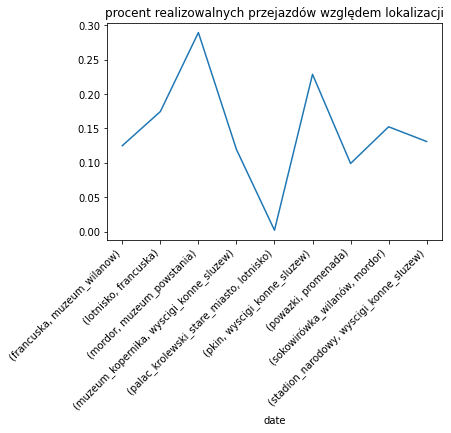

In [7]:
(df.groupby(['location_from_name', 'location_to_name']).sum()['realisable']/df.groupby(['location_from_name', 'location_to_name']).count()['realisable']).plot()
plt.title('procent realizowalnych przejazdów względem lokalizacji')
plt.xticks(rotation=45, ha='right')
plt.xlabel('date')
print('usually about 15% of routes are realisable')

In [190]:
df.groupby(['location_from_name', 'location_to_name']).sum()

response_nr  plan.from.lon  \
location_from_name           location_to_name                                   
francuska                    muzeum_wilanow            3157460   34444.234388   
lotnisko                     francuska                 2474739   27260.371710   
mordor                       muzeum_powstania          2581423   27977.040688   
muzeum_kopernika             wyscigi_konne_sluzew      3460452   37830.680053   
palac_krolewski_stare_miasto lotnisko                  1632156   19964.526925   
pkin                         wyscigi_konne_sluzew      3067957   33672.661602   
powazki                      promenada                 3091198   34765.623711   
sokowirovka_wilanow          mordor                    2762780   30091.009637   
stadion_narodowy             wyscigi_konne_sluzew      3385556   36785.974784   

                                                   plan.from.lat  \
location_from_name           location_to_name                      
francuska                    muzeum_wilanow         85455.676847   
lotnisko                     francuska              67814.060990   
mordor                       muzeum_powstania       69502.844383   
muzeum_kopernika             wyscigi_konne_sluzew   93983.132945   
palac_krolewski_stare_miasto lotnisko               49636.515610   
pkin                         wyscigi_konne_sluzew   83727.752051   
powazki                      promenada              86582.888109   
sokowirovka_wilanow          mordor                 74482.731557   
stadion_narodowy             wyscigi_konne_sluzew   91313.097971   

                                                    plan.to.lon   plan.to.lat  \
location_from_name           location_to_name                                   
francuska                    muzeum_wilanow        34504.054237  85342.269163   
lotnisko                     francuska             27370.112900  67904.877690   
mordor                       muzeum_powstania      27946.738620  69575.346209   
muzeum_kopernika             wyscigi_konne_sluzew  37802.956923  93837.044430   
palac_krolewski_stare_miasto lotnisko              19921.040865  49556.429185   
pkin                         wyscigi_konne_sluzew  33684.346830  83613.553209   
powazki                      promenada             34978.673480  86547.583072   
sokowirovka_wilanow          mordor                29993.403980  74512.058393   
stadion_narodowy             wyscigi_konne_sluzew  36731.277766  91176.850286   

                                                   itinerary_nr  duration  \
location_from_name           location_to_name                               
francuska                    muzeum_wilanow                3369   5406088   
lotnisko                     francuska                     1906   4193627   
mordor                       muzeum_powstania              3260   3483586   
muzeum_kopernika             wyscigi_konne_sluzew          3596   6551454   
palac_krolewski_stare_miasto lotnisko                      1323   3631261   
pkin                         wyscigi_konne_sluzew          2954   4794590   
powazki                      promenada                     3086   5863763   
sokowirovka_wilanow          mordor                        3553   3440693   
stadion_narodowy             wyscigi_konne_sluzew          3405   6754402   

                                                   walkTime  transitTime  \
location_from_name           location_to_name                              
francuska                    muzeum_wilanow         2024190      2845560   
lotnisko                     francuska              1328166      2639100   
mordor                       muzeum_powstania       1338402      1916580   
muzeum_kopernika             wyscigi_konne_sluzew   2451069      3511140   
palac_krolewski_stare_miasto lotnisko               1476729      1984800   
pkin                         wyscigi_konne_sluzew   2069397      2594700   
powazki                      promenada              2123989   

In [295]:
def plot_routes(routes, counts, location_from_name, location_to_name, ax):
    lons = [20.9, 21.1]
    lats = [52.1, 52.3]
    counts = np.array(counts) / max(counts)
    # Bounding box
    min_lon = min(lons)
    max_lon = max(lons)
    min_lat = min(lats)
    max_lat = max(lats)
    target_crs = 'EPSG:3857'
    transformer = pyproj.Transformer.from_crs('EPSG:4326', target_crs)
    warsaw_img, warsaw_extent = ctx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=ctx.providers.OpenStreetMap.Mapnik)

# Plot the basemap
    ax.imshow(warsaw_img, extent=warsaw_extent)
    for route, count in zip(routes, counts):
        projected_coords = [transformer.transform(lon, lat) for lat, lon in route]
        projected_lons, projected_lats = zip(*projected_coords)
        lons = [projected_lons[0], projected_lons[-1]]
        lats = [projected_lats[0], projected_lats[-1]]
        ax.scatter(lons, lats, color = 'red', s = 100) 
        sc = ax.plot(projected_lons, projected_lats, marker=',', linestyle='-', c=plt.cm.plasma(count))  # Default to blue for unknown modes
        ax.grid(False)
        # Hide axes ticks
        ax.set_xticks([])
        ax.set_yticks([])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    ax.axis(warsaw_extent)

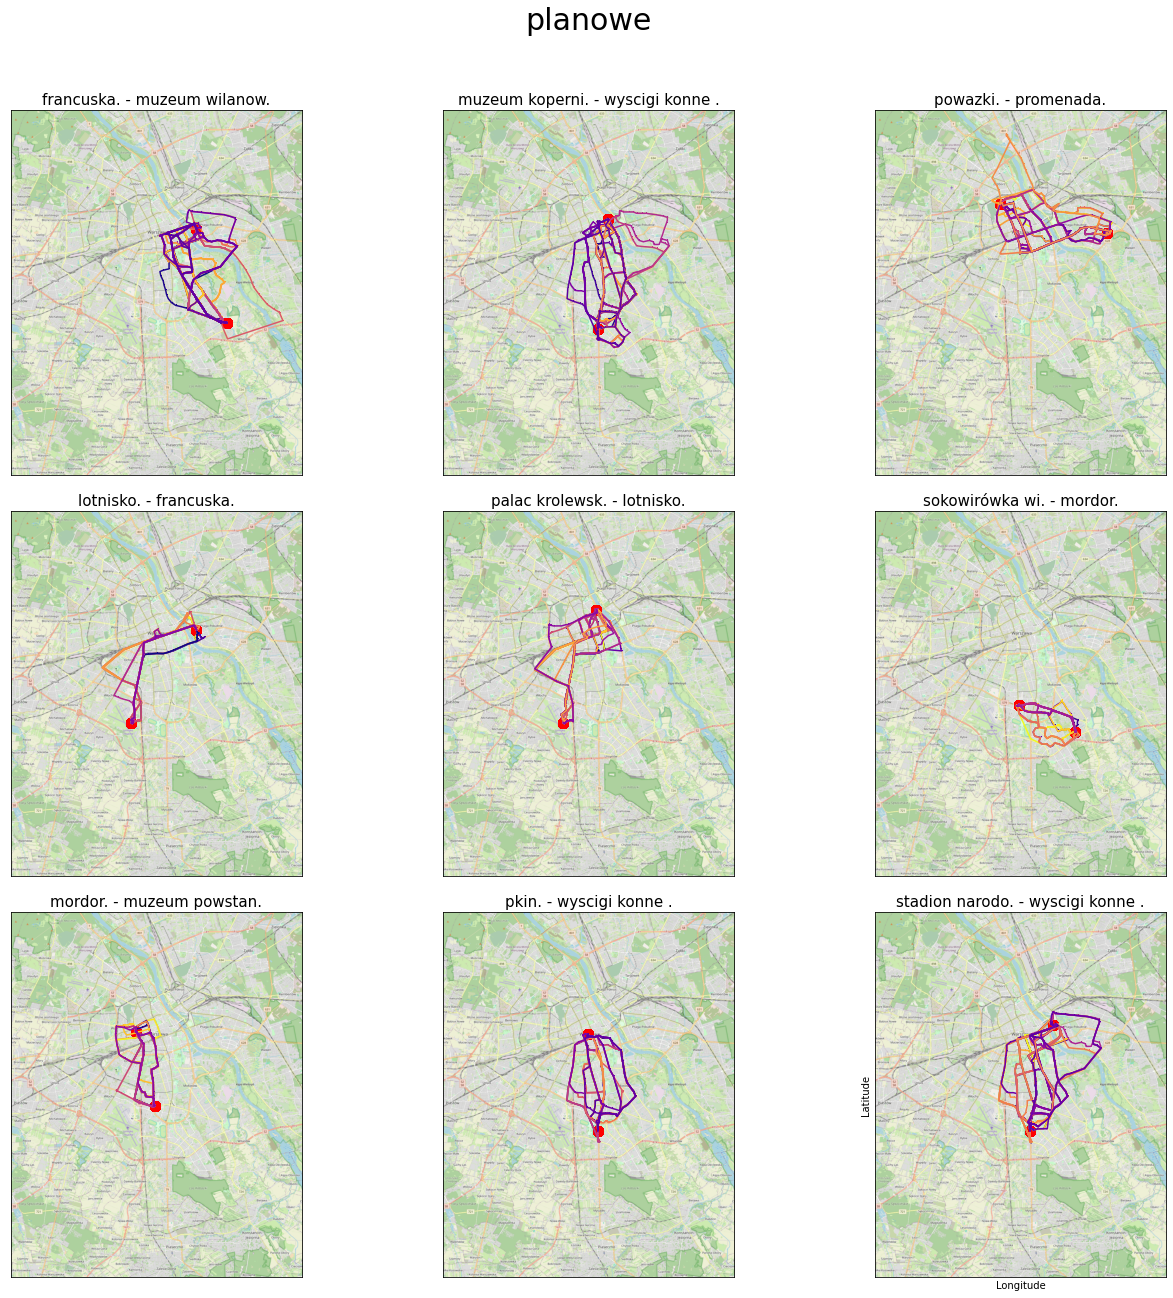

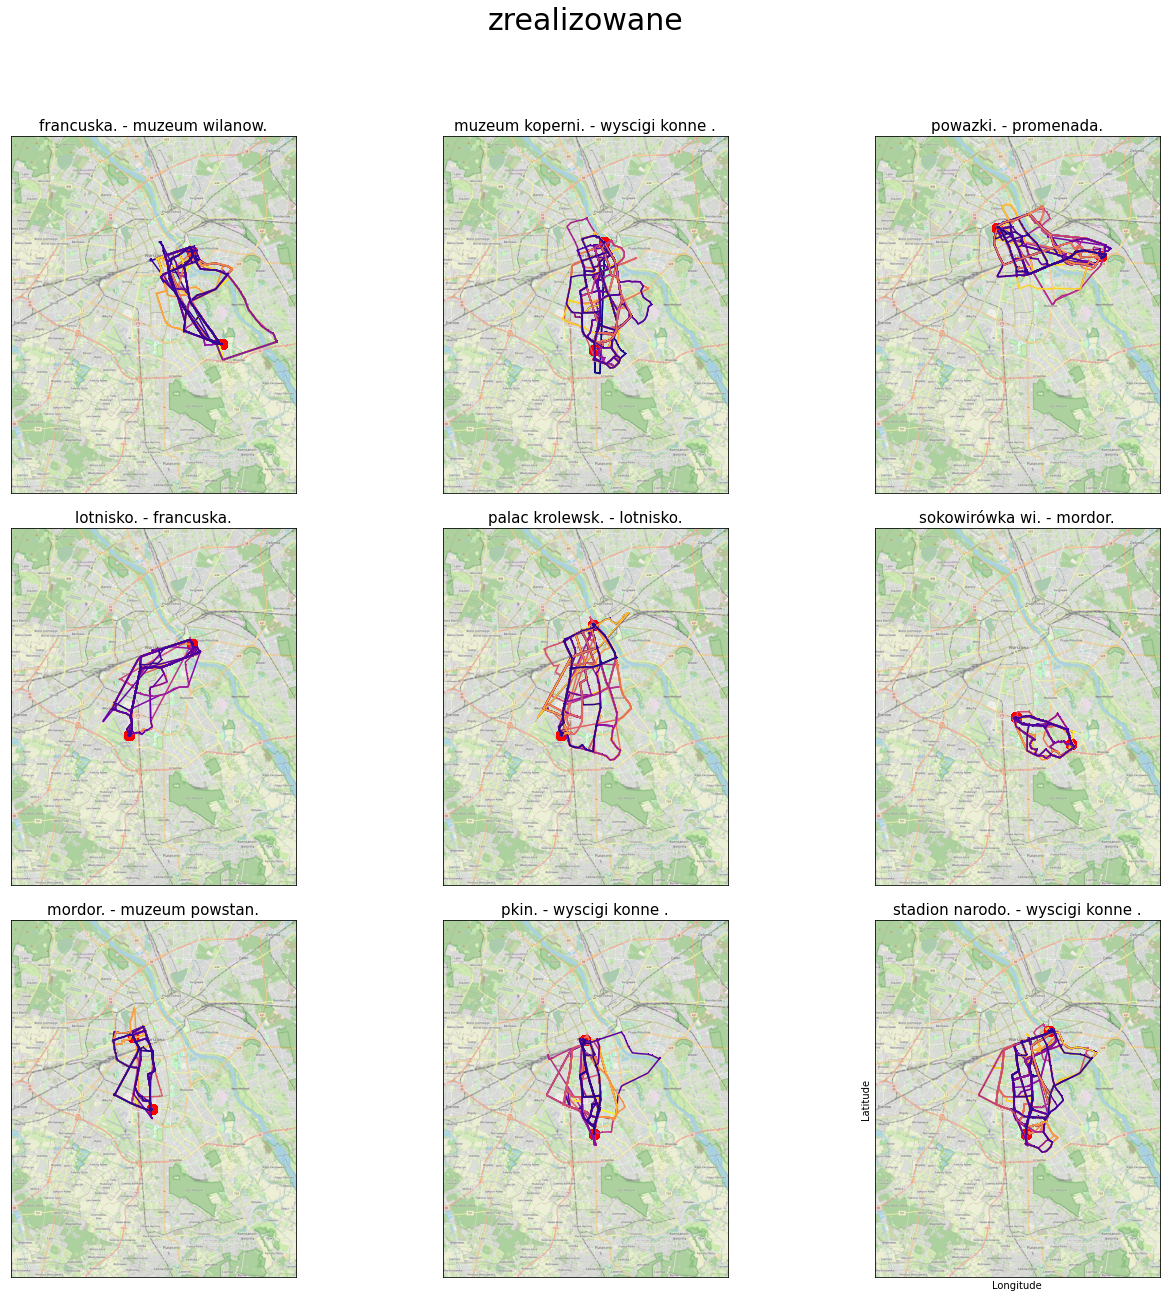

In [296]:
from matplotlib.colors import Normalize
locations = [
    ('francuska', 'muzeum_wilanow'),
    ('lotnisko', 'francuska'),
    ('mordor', 'muzeum_powstania'),
    ('muzeum_kopernika', 'wyscigi_konne_sluzew'),
    ('palac_krolewski_stare_miasto', 'lotnisko'),
    ('pkin', 'wyscigi_konne_sluzew'),
    ('powazki', 'promenada'),
    ('sokowirówka_wilanów', 'mordor'),
    ('stadion_narodowy', 'wyscigi_konne_sluzew')
]
norm = Normalize(vmin=0, vmax=10)
fig, ax = plt.subplots(3,3)
fig.set_size_inches(18, 18)
fig.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0.1)
for i, (location_from_name, location_to_name) in enumerate(locations):
    routes = df[(df['location_from_name'] == location_from_name) & (df['location_to_name'] == location_to_name)]['route_coordinates_str'].unique()



    counts = [df[df['route_coordinates_str'] == route].shape[0] for route in routes]
    counts = [index for index, _ in sorted(enumerate(counts), key=lambda x: x[1])]



    routes = [ast.literal_eval(x) for x in routes]
    plot_routes(routes, counts, location_from_name, location_to_name, ax[i%3, i//3])
    ax[i%3, i//3].set_title(f'{location_from_name[:14].replace("_", " ")}. - {location_to_name[:14].replace("_", " ")}.', fontsize = 15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle('planowe', fontsize = 30)
plt.savefig('../outputs/OTP/benchmark/przykladowe_planowe.png', dpi = 200)
plt.show()

fig, ax = plt.subplots(3,3)
fig.set_size_inches(18, 18)
fig.subplots_adjust(left=0, bottom=0, right=1, top=None, wspace=0, hspace=0.1)
for i, (location_from_name, location_to_name) in enumerate(locations):
    routes = rt_df[(rt_df['location_from_name'] == location_from_name) & (rt_df['location_to_name'] == location_to_name)]['route_coordinates_str'].unique()
    counts = [rt_df[rt_df['route_coordinates_str'] == route].shape[0] for route in routes] 
    counts = [index for index, _ in sorted(enumerate(counts), key=lambda x: x[1])]
    routes = [ast.literal_eval(x) for x in routes]
    plot_routes(routes, counts, location_from_name, location_to_name, ax[i%3, i//3])
    ax[i%3, i//3].set_title(f'{location_from_name[:14].replace("_", " ")}. - {location_to_name[:14].replace("_", " ")}.', fontsize = 15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle('zrealizowane', fontsize = 30)
plt.savefig('../outputs/OTP/benchmark/przykładowe_rzeczywiste.png', dpi = 200)
plt.show()

## analiza czemu trasy nie przeszły

In [39]:
tmp = df.merge(rt_df, on = ['requestParameters.date', 'requestParameters.time', 'route_coordinates_str'], how = 'left', suffixes=['_expected', '_real'])
df['time_difference'] = tmp[['duration_expected', 'duration_real']].apply(lambda x: x.duration_real - x.duration_expected, axis=1)
df['realisable'] = [not x for x in np.isnan(df['time_difference'])]
df_nonrealisable = df[np.negative(df['realisable'])]

[48.69533172910067, 48.69533172910067] [2.989772258171331e-12, 2.989772258171331e-12]


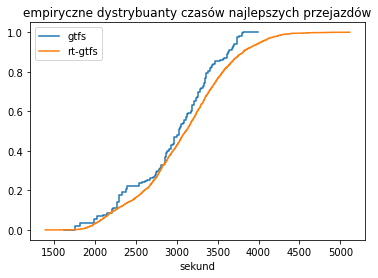

In [29]:
#  "How likely is it that we would see two sets of samples like this if they were drawn from the same (but unknown) probability distribution?".
from scipy import stats
ecdfs = []
h_stat = []
p_val = []
for sample, name in zip([df.iloc[df.groupby(['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'])['duration'].idxmin()]['duration']\
               , rt_df.iloc[rt_df.groupby(['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'])['duration'].idxmin()]['duration']], ['gtfs', 'rt-gtfs']):
    ecdfs.append(stats.ecdf(sample))
for ecdf in ecdfs:
    ecdf.cdf.plot(label = name)
plt.title("empiryczne dystrybuanty czasów najlepszych przejazdów")
plt.legend(['gtfs', 'rt-gtfs'])
kruskal = stats.kruskal(*samples)
h_stat.append(kruskal.statistic)
p_val.append(kruskal.pvalue)
print(h_stat, p_val)
plt.xlabel('sekund')
plt.savefig('../outputs/OTP/benchmark/rozklad_duration.png', dpi = 200)

sprawdzić czy przy podróżach czas podróży całkowity - czy pochodzą z tego samego rozkładu   - nie pochodzą  
dlaczego podróże się nie udały

C:\Users\mipec\AppData\Local\Temp\ipykernel_22236\1405987647.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = [best_df[(best_df['location_from_name'] == loc_from) & (best_rt['location_to_name'] == loc_to)]['duration'], best_rt[(best_df['location_from_name'] == loc_from) & (best_rt['location_to_name'] == loc_to)]['duration']]
C:\Users\mipec\AppData\Local\Temp\ipykernel_22236\1405987647.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = [best_df[(best_df['location_from_name'] == loc_from) & (best_rt['location_to_name'] == loc_to)]['duration'], best_rt[(best_df['location_from_name'] == loc_from) & (best_rt['location_to_name'] == loc_to)]['duration']]
C:\Users\mipec\AppData\Local\Temp\ipykernel_22236\1405987647.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples = [best_df[(best_df['location_from_name'] == loc_from) & (best_rt['location_to_name'] == loc_to)]['dura

francuska		muzeum wilanow		 p-val =  [0.5648708373596039], h-stat = [0.3313404657017036]
palac krolewski stare miasto		lotnisko		 p-val =  [0.008815858177902036], h-stat = [6.859756097560971]
mordor		muzeum powstania		 p-val =  [0.08331818193509123], h-stat = [2.998956158663882]
pkin		wyscigi konne sluzew		 p-val =  [2.3906120760527257e-05], h-stat = [17.849666142969365]
sokowirówka wilanów		mordor		 p-val =  [0.020754590798754982], h-stat = [5.347282766637615]
muzeum kopernika		wyscigi konne sluzew		 p-val =  [0.04541609045106667], h-stat = [4.0031210986267105]
powazki		promenada		 p-val =  [0.08282525735857266], h-stat = [3.0085714285714324]
stadion narodowy		wyscigi konne sluzew		 p-val =  [1.2298412331351044e-05], h-stat = [19.11639113589783]
lotnisko		francuska		 p-val =  [0.46159041345481033], h-stat = [0.5420353982300944]


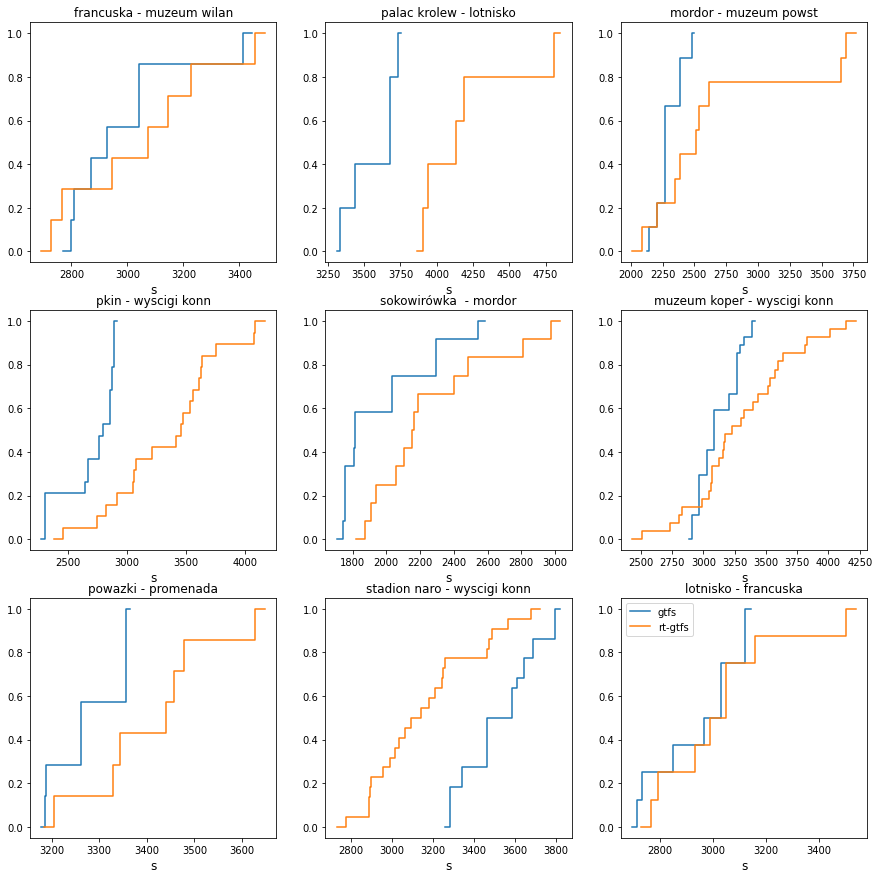

In [68]:
best_df = df.iloc[df.groupby(['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'])['duration'].idxmin()]
best_rt = rt_df.iloc[rt_df.groupby(['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'])['duration'].idxmin()]

fig, ax = plt.subplots(3,3)
ax = np.array(ax).flatten()
fig.set_size_inches(15,15)
for i, (loc_from, loc_to) in enumerate(zip(df[['location_from_name', 'location_to_name']].drop_duplicates()['location_from_name'], df[['location_from_name', 'location_to_name']].drop_duplicates()['location_to_name'])):
    samples = [best_df[(best_df['location_from_name'] == loc_from) & (best_rt['location_to_name'] == loc_to)]['duration'], best_rt[(best_df['location_from_name'] == loc_from) & (best_rt['location_to_name'] == loc_to)]['duration']]
    ecdfs = []
    h_stat = []
    p_val = []
    for sample in samples:
            ecdfs.append(stats.ecdf(sample))
    kruskal = stats.kruskal(*samples)
    h_stat.append(kruskal.statistic)
    p_val.append(kruskal.pvalue)
    print(f'{loc_from.replace("_", " ")}\t\t{loc_to.replace("_", " ")}\t\t p-val =  {p_val}, h-stat = {h_stat}')
    for ecdf in ecdfs:
        ecdf.cdf.plot(ax=ax[i])
        ax[i].set_title(f'{loc_from[:12].replace("_", " ")} - {loc_to[:12].replace("_", " ")}')
        ax[i].set_xlabel('s', fontsize = 12)
plt.legend(['gtfs', 'rt-gtfs'])
plt.savefig('../outputs/OTP/benchmark/testy_lokacje.png', dpi = 200)

# przejazdy które się nie udały - dlaczego

In [ ]:
# TODO: sprawdzić czy działa już przesuwanie o 'agencyTimeZoneOffset' - histogramy i czemu nie działają przejazdy :))

In [51]:
def normalize_and_append(row):
    normalized_data = pd.json_normalize(row['legs'])

    normalized_data['legStartTime'] = pd.to_datetime(normalized_data['startTime'] + normalized_data['agencyTimeZoneOffset'], unit='ms')
    normalized_data['legEndTime'] = pd.to_datetime(normalized_data['endTime'] + normalized_data['agencyTimeZoneOffset'], unit='ms')
    
    # Extract date and time components
    normalized_data['leg_nr'] = list(range(normalized_data.shape[0]))

    # Set the types of normalized_data columns to match the types of row columns
    for col in row.index:
        if col != 'legs':
            normalized_data[col] = [row[col]] * normalized_data.shape[0]
            if type(row[col]) is not list:
                normalized_data[col] = normalized_data[col].astype(type(row[col]))

    return normalized_data

In [52]:
tmp = df.merge(rt_df, on = ['requestParameters.date', 'requestParameters.time', 'route_coordinates_str'], how = 'left', suffixes=['_expected', '_real'])
df['time_difference'] = tmp[['duration_expected', 'duration_real']].apply(lambda x: x.duration_real - x.duration_expected, axis=1)
df['realisable'] = [not x for x in np.isnan(df['time_difference'])]
df_nonrealisable = df[np.negative(df['realisable'])]

In [53]:
df_legs = pd.DataFrame()
for num, row in df_nonrealisable.iterrows():
    leg = normalize_and_append(row)
    # leg['response_nr'] = row['response_nr']
    # leg['itinerary_nr'] = row['itinerary_nr']
    
    df_legs = pd.concat([df_legs, leg])

In [54]:
# df_legs['tripId'] = df_legs['tripId'].apply(lambda x: x[2:] if isinstance(x, str) else x)
# df_legs['to.stopId'] = df_legs['to.stopId'].apply(lambda x: x[2:] if isinstance(x, str) else x)
# df_legs['from.stopId'] = df_legs['from.stopId'].apply(lambda x: x[2:] if isinstance(x, str) else x)

# df_legs['to.arrival'] = pd.to_datetime(df_legs['to.arrival'], unit='ms')
# df_legs['to.departure'] = pd.to_datetime(df_legs['to.departure'], unit='ms')
# df_legs['from.arrival']= pd.to_datetime(df_legs['from.arrival'], unit='ms')
# df_legs['from.departure']= pd.to_datetime(df_legs['from.departure'], unit='ms')

# df_legs['to.arrivalDate'] = df_legs['to.arrival'].dt.strftime('%Y-%m-%d')
# df_legs['to.arrivalTime'] = df_legs['to.arrival'].dt.strftime('%H:%M:%S')

# df_legs['from.arrivalDate'] = df_legs['from.arrival'].dt.strftime('%Y-%m-%d')
# df_legs['from.arrivalTime'] = df_legs['from.arrival'].dt.strftime('%H:%M:%S')

# df_legs.drop(columns=['departureDelay', 'arrivalDelay', 'realTime', 'time_difference', 'alerts', 'agencyTimeZoneOffset', 'interlineWithPreviousLeg', \
#                       'steps',  'rentedBike', 'walkingBike', 'legGeometry.points', 'legGeometry.length', 'agencyName', 'agencyUrl', 'serviceDate'], inplace=True)
# print(df_legs.shape)

# utilizing TimeZoneOffset
df_legs['to.arrival'] = df_legs['to.arrival'] + df_legs['agencyTimeZoneOffset']
df_legs['to.departure'] = df_legs['to.departure'] + df_legs['agencyTimeZoneOffset']
df_legs['from.arrival'] = df_legs['from.arrival'] + df_legs['agencyTimeZoneOffset']
df_legs['from.departure'] = df_legs['from.departure'] + df_legs['agencyTimeZoneOffset']

# Optimizing slicing
columns_to_slice = ['tripId', 'to.stopId', 'from.stopId']
df_legs[columns_to_slice] = df_legs[columns_to_slice].apply(lambda x: x.str.slice(2) if x.dtype == 'O' else x)

# Optimizing datetime conversion
datetime_columns = ['to.arrival', 'to.departure', 'from.arrival', 'from.departure']
df_legs[datetime_columns] = df_legs[datetime_columns].apply(pd.to_datetime, unit='ms')

# Extracting date and time
df_legs['to.arrivalDate'] = df_legs['to.arrival'].dt.strftime('%Y-%m-%d')
df_legs['to.arrivalTime'] = df_legs['to.arrival'].dt.strftime('%H:%M:%S')

df_legs['from.arrivalDate'] = df_legs['from.arrival'].dt.strftime('%Y-%m-%d')
df_legs['from.arrivalTime'] = df_legs['from.arrival'].dt.strftime('%H:%M:%S')

# Dropping unnecessary columns
columns_to_drop = ['departureDelay', 'arrivalDelay', 'realTime', 'time_difference', 'alerts', 'agencyTimeZoneOffset', 'interlineWithPreviousLeg',
                    'steps', 'rentedBike', 'walkingBike', 'legGeometry.points', 'legGeometry.length', 'agencyName', 'agencyUrl', 'serviceDate']
df_legs.drop(columns=columns_to_drop, inplace=True)

print(df_legs.shape)


(48068, 60)


In [56]:
import copy

directory = "../dane/gtfs-drive/"
df_legs_merged_rt = pd.DataFrame()

for date in df_legs[df_legs['mode'] != 'WALK']['requestParameters.date'].unique():
    print(date)
    
    # Real-time data
    filepath_rt = directory + date + '-rt.gtfs'
    rt_df_stoptimes = pd.read_csv(filepath_rt + "/stop_times.txt")
    rt_df_stoptimes['stop_id'] = rt_df_stoptimes['stop_id'].str.strip()

    rt_from = copy.deepcopy(rt_df_stoptimes)
    rt_to = copy.deepcopy(rt_df_stoptimes)
    rt_from.columns = rt_from.columns.map(lambda x: "rtLegFrom_"+str(x))
    rt_to.columns = rt_to.columns.map(lambda x: "rtLegTo_"+str(x))

    tmp = df_legs[df_legs['requestParameters.date'] == date].merge(rt_from, how='left', left_on=['tripId', 'from.stopId'], right_on=['rtLegFrom_trip_id', 'rtLegFrom_stop_id'])
    tmp = tmp.merge(rt_to, how='left', left_on=['tripId', 'to.stopId'], right_on=['rtLegTo_trip_id', 'rtLegTo_stop_id'])

    # Scheduled data
    filepath_scheduled = directory + date + '.gtfs'
    df_stoptimes = pd.read_csv(filepath_scheduled + "/stop_times.txt")
    df_stoptimes['stop_id'] = df_stoptimes['stop_id'].str.strip()

    df_from = copy.deepcopy(df_stoptimes)
    df_to = copy.deepcopy(df_stoptimes)
    df_from.columns = df_from.columns.map(lambda x: "legFrom_"+str(x))
    df_to.columns = df_to.columns.map(lambda x: "legTo_"+str(x))

    tmp2 = tmp.merge(df_from, how='left', left_on=['tripId', 'from.stopId'], right_on=['legFrom_trip_id', 'legFrom_stop_id'])
    tmp2 = tmp2.merge(df_to, how='left', left_on=['tripId', 'to.stopId'], right_on=['legTo_trip_id', 'legTo_stop_id'])
    
    df_legs_merged_rt = pd.concat([df_legs_merged_rt, tmp2])

2022-03-30
2022-03-31
2022-04-13
2022-04-14
2022-04-19
2022-04-20
2022-04-21
2022-04-26
2022-04-27
2022-04-28
2022-05-10
2022-05-11
2022-05-12
2022-05-17
2022-05-19
2022-05-24
2022-05-25
2022-05-28
2022-05-31
2022-06-01
2022-06-02
2022-06-07
2022-06-08
2022-06-09
2022-06-14
2022-06-15
2022-06-16
2022-06-21
2022-06-22
2022-06-23
2022-11-22
2022-11-23
2022-11-24
2022-11-29
2022-11-30
2022-12-01
2022-12-06
2022-12-07
2022-12-08
2022-12-13
2022-12-14
2022-12-15
2023-04-25
2023-04-26
2023-04-27
2023-05-02
2023-05-25
2023-05-30
2023-05-31
2023-06-01
2023-06-06
2023-06-07
2023-06-13
2023-06-14
2023-06-15


In [57]:
for col in df_legs_merged_rt.columns:
    if df_legs_merged_rt[col].dtype != list:
        if df_legs_merged_rt[col].nunique() <= 1:
            try:
                df_legs_merged_rt.drop(inplace = True, columns = [col])
            except:
                print(col)

cols = [
        'legFrom_trip_id',
        'rtLegFrom_trip_id',
        'legTo_trip_id',
        'rtLegTo_trip_id',
        'legFrom_stop_sequence',
        'rtLegFrom_stop_sequence',
        'legTo_stop_sequence',
        'rtLegTo_stop_sequence',
        'legFrom_stop_id',
        'rtLegFrom_stop_id',
        'legTo_stop_id',
        'rtLegTo_stop_id',
        'plan.from.lon',
        'plan.from.lat', 
        'plan.to.lon', 
        'plan.to.lat',
        
        
]
df_legs_merged_rt.drop(inplace=True, columns = cols)
df_legs_merged_rt = df_legs_merged_rt.reset_index(drop=True)
df_legs_merged_rt.head()

startTime              endTime  distance  generalizedCost  mode  \
0  2022-03-30 04:35:52  2022-03-30 05:23:53     70.48             5414  WALK   
1  2022-03-30 04:35:52  2022-03-30 05:23:53   2739.75             5414   BUS   
2  2022-03-30 04:35:52  2022-03-30 05:23:53    159.15             5414  WALK   
3  2022-03-30 04:35:52  2022-03-30 05:23:53   5350.69             5414   BUS   
4  2022-03-30 04:35:52  2022-03-30 05:23:53    210.14             5414  WALK   

   transitLeg         route  duration              from.name   from.lon  ...  \
0       False                    2881                 Origin  21.053933  ...   
1        True        Utrata      2881           Francuska 01  21.054000  ...   
2       False                    2881      pl.Na Rozdrożu 06  21.026000  ...   
3        True  Konwiktorska      2881      pl.Na Rozdrożu 01  21.025000  ...   
4       False                    2881  Dolina Służewiecka 01  21.044000  ...   

   from.arrivalDate from.arrivalTime rtLegFrom_arrival_time  \
0               NaN              NaN                    NaN   
1        2022-03-30         06:37:00               06:36:38   
2        2022-03-30         06:44:00                    NaN   
3        2022-03-30         06:46:12               06:50:11   
4        2022-03-30         07:01:00                    NaN   

  rtLegFrom_departure_time rtLegTo_arrival_time  rtLegTo_departure_time  \
0                      NaN                  NaN                     NaN   
1                 06:36:48             06:44:04                06:44:27   
2                      NaN                  NaN                     NaN   
3                 06:50:31             07:01:47                07:02:17   
4                      NaN                  NaN                     NaN   

   legFrom_arrival_time legFrom_departure_time legTo_arrival_time  \
0                   NaN                    NaN                NaN   
1              06:37:00               06:37:00           06:44:00   
2                   NaN                    NaN                NaN   
3              06:49:00               06:49:00           07:01:00   
4                   NaN                    NaN                NaN   

  legTo_departure_time  
0                  NaN  
1             06:44:00  
2                  NaN  
3             07:01:00  
4                  NaN  

[5 rows x 62 columns]

In [211]:
df_legs_merged_rt = df_legs_merged_rt.reset_index(drop=True)
ts = pd.to_datetime(df_legs_merged_rt['rtLegFrom_departure_time'].str.strip(), format = '%H:%M:%S') - pd.to_datetime(df_legs_merged_rt['legStartTime'].dt.strftime('%H:%M:%S'), format = '%H:%M:%S')
ts = ts.dt.total_seconds()
df_legs_merged_rt['departureDelay'] = ts

ts = pd.to_datetime(df_legs_merged_rt['rtLegTo_arrival_time'].str.strip(), format = '%H:%M:%S') - pd.to_datetime(df_legs_merged_rt['legEndTime'].dt.strftime('%H:%M:%S'), format = '%H:%M:%S')
ts = ts.dt.total_seconds()
df_legs_merged_rt['arrivalDelay'] = ts

df_legs_merged_rt.rename(columns = {'routeShortName':'line'})

df_legs_merged_rt['transfer_nr'] = df_legs_merged_rt[df_legs_merged_rt['mode'] != 'WALK'].groupby(['response_nr', 'itinerary_nr']).cumcount().astype(int)
df_legs_merged_rt['transfer_nr'] = df_legs_merged_rt['transfer_nr'].apply(lambda x: x if not np.isnan(x) else -1)

In [218]:
lower_quantile = df_legs_merged_rt['arrivalDelay'].quantile(0.025)
upper_quantile = df_legs_merged_rt['arrivalDelay'].quantile(0.975)
# Filter the dataframe to keep values within the 2.5% - 97.5% range
df_legs_merged_rt = df_legs_merged_rt[(df_legs_merged_rt['arrivalDelay'] >= lower_quantile) & (df_legs_merged_rt['arrivalDelay'] <= upper_quantile)]

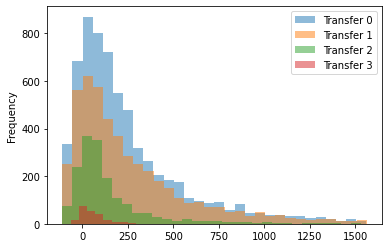

In [235]:
import matplotlib.pyplot as plt

# Assuming df_legs_merged_rt is your DataFrame
# Assuming 'transfer_nr' is a column in your DataFrame

# Create a figure and axis
fig, ax = plt.subplots()

# Group by 'transfer_nr' and plot histograms
for transfer_nr, group in df_legs_merged_rt.groupby('transfer_nr')['arrivalDelay']:
    group.plot(kind='hist', bins=30, alpha=0.5, ax=ax, label=f'Transfer {int(transfer_nr)}')

# Add legend
ax.legend()

# Display the plot
plt.show()


In [232]:
df_legs_merged_rt['legRealisable'] = df_legs_merged_rt['departureDelay'] <= 0
df_legs_merged_rt.groupby('transfer_nr')['legRealisable'].mean()

C:\Users\mipec\AppData\Local\Temp\ipykernel_17452\891433651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_legs_merged_rt['legRealisable'] = df_legs_merged_rt['departureDelay'] <= 0


transfer_nr
0.0    0.170924
1.0    0.139860
2.0    0.177177
3.0    0.213974
Name: legRealisable, dtype: float64